## Pipeline 1: 
- ### learn the model comparison between a K and a Na channel model. 
- ### predict a model idx given observed data 
- ### learn the posterior over model parameters of the predicted model

In [2]:
import delfi.distribution as dd
import matplotlib as mpl
import numpy as np
import os
import pandas as pd
import pickle
import time

from delfi.generator import Default
from delfi.utils.viz import plot_pdf
from delfi.distribution.mixture import MoG

import sys 
sys.path.append('../../../lfi-models/')
from lfimodels.channelomics.ChannelSingle import ChannelSingle
from lfimodels.channelomics.ChannelSuper import ChannelSuper
from lfimodels.channelomics.ChannelStats import ChannelStats
from matplotlib import pyplot as plt

import sys 
sys.path.append('../../')
from model_comparison.utils import *
from model_comparison.mdns import *

%matplotlib inline

## Set "k" or "na" as underlying ground truth model, generate observed data 

In [3]:
channel_type = 'k'
result_dict = dict()

In [4]:
GT = {'k': np.array([9, 25, 0.02, 0.002]),
      'na': np.array([-35, 9, 0.182, 0.124, -50, -75, 5, -65, 6.2, 0.0091, 0.024])}

LP = {'k': ['qa','tha','Ra','Rb'],
      'na': ['tha','qa','Ra','Rb','thi1','thi2','qi','thinf','qinf','Rg','Rd']}

E_channel = {'k': -86.7, 'na': 50}
fact_inward = {'k': 1, 'na': -1}

gt = GT[channel_type]
cython = True
third_exp_model = True

n_params = len(gt)
labels_params = LP[channel_type]
prior_lims = np.sort(np.concatenate((0.2 * gt.reshape(-1,1), 1.3 * gt.reshape(-1,1)), axis=1))

In [5]:
# generate observed data
n_params_obs = len(gt)
m_obs = ChannelSingle(channel_type=channel_type, n_params=n_params_obs, cython=cython)
s = ChannelStats(channel_type=channel_type)

xo = m_obs.gen(gt.reshape(1,-1))
xo_stats = s.calc(xo[0])

/Users/Jan/.local/lib/python3.6/site-packages/scipy-1.1.0-py3.6-macosx-10.7-x86_64.egg/scipy/signal/signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/Users/Jan/.local/lib/python3.6/site-packages/scipy-1.1.0-py3.6-macosx-10.7-x86_64.egg/scipy/signal/signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/Users/Jan/.local/lib/python3.6/site-packages/scipy-1.1.0-py3.6-macosx-10.7-x86_64.egg/scipy/signal/signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensiona

## Load training data and split test data

In [7]:
filename = 'training_data_k_na_N10000seed3.p'
folder = '../data/'
fullpath = os.path.join(folder, filename)

with open(fullpath, 'rb') as f: 
    result_dict = pickle.load(f)

In [8]:
params_k, sx_k, gt_k, prior_lims_k, params_na, sx_na, gt_na, prior_lims_na, seed, n_samples, cython = result_dict.values()

ntest = 1000
n, n_stats = sx_na.shape
ntrain = n - ntest

# shuffle and set up model index target vector 
sx = np.vstack((sx_k[:ntrain, :], sx_na[:ntrain, :]))
sx_test = np.vstack((sx_k[ntrain:, :], sx_na[ntrain:, :]))

# define model indices
m = np.hstack((np.zeros(ntrain), np.ones(ntrain))).squeeze().astype(int).tolist()
m_test = np.hstack((np.zeros(ntest), np.ones(ntest))).squeeze().astype(int).tolist()

# normalize data 
sx_zt, data_norm = normalize(sx)

## Set up the NN and train it 

In [9]:
model_models = ClassificationMDN(n_input=n_stats, n_hidden_units=4, n_hidden_layers=1)
optimizer = torch.optim.Adam(model_models.parameters(), lr=0.01)
trainer = Trainer(model_models, optimizer, verbose=True, classification=True)

n_epochs = 10 
n_minibatch = int(ntrain / 100)

# train with training data
loss_trace = trainer.train(sx_zt, m, n_epochs=n_epochs, n_minibatch=n_minibatch)

training: 100%|██████████| 10/10 [00:01<00:00,  5.58it/s]


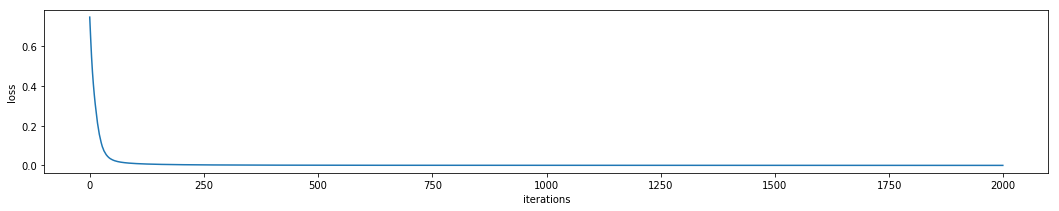

In [10]:
plt.figure(figsize=(18, 3))
plt.plot(loss_trace)
plt.ylabel('loss')
plt.xlabel('iterations');

## Predict underlying model given observed data

In [11]:
# predict 
# normalize using training data normalization 
sx_obs_zt, _ = normalize(xo_stats, data_norm)

p_vec = model_models.predict(sx_obs_zt)
print('True model: {}'.format(channel_type))
print('P(K | sx) = {:.2f}'.format(p_vec[0]))
print('P(Na | sx) = {:.2f}'.format(p_vec[1]))

True model: k
P(K | sx) = 1.00
P(Na | sx) = 0.00


## Predict test data and calculate test cross entropy loss

In [13]:
sx_test_zt, data_norm = normalize(sx_test, data_norm)
p = model_models.predict(sx_test_zt)[:, 1]
y = np.array(m_test)

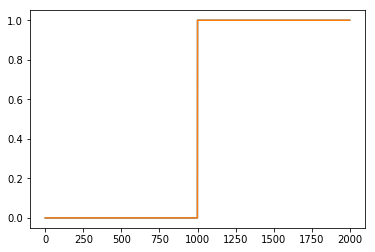

In [17]:
plt.plot(m_test)
plt.plot(p)

array([9.3218063e-05, 9.3238239e-05, 9.3189352e-05, ..., 9.9990749e-01,
       9.9990755e-01, 9.9990749e-01], dtype=float32)

In [14]:
cel = -(y * np.log(p) + (1 - y) * np.log(1 - p))
print('Cross entropy test loss: {:.4f}'.format(cel.sum()))

Cross entropy test loss: 0.1858


In [ ]:
model_idx_posterior_dict = dict(sx_train=sx, sx_test=sx_test, mtrain=m, mtest=m_test, data_norm=data_norm, 
                           sx_obs=xo_stats, model_idx_mdn=model_models, prior_lims_k=prior_lims_k, 
                           prior_lims_na=prior_lims_na)

## Given the predicted underlying model we can learn the posterior of its parameters

In [ ]:
predicted_model_idx = np.argmax(p_vec)
predicted_channel_type = ['k', 'na'][predicted_model_idx]
gt = GT[channel_type]
n_params_pred = len(gt)

# get corresponding data 
ntest = 1000
ntrain = result_dict['sx_' + predicted_channel_type].shape[0] - ntest
sx_pred = result_dict['sx_' + predicted_channel_type][:ntrain, ]
sx_pred_test = result_dict['sx_' + predicted_channel_type][ntrain:]

params_pred = result_dict['params_' + predicted_channel_type][:ntrain, ]
params_pred_test = result_dict['params_' + predicted_channel_type][ntrain:, ]

In [ ]:
predicted_channel_type

In [ ]:
# define a network to approximate the posterior with a MoG 
model_params_mdn = MultivariateMogMDN(ndim_input=n_stats, ndim_output=n_params_pred, n_hidden_layers=2, 
                                      n_hidden_units=10, n_components=1)
optimizer = torch.optim.Adam(model_params_mdn.parameters(), lr=0.01)
trainer = Trainer(model_params_mdn, optimizer, verbose=True)

In [ ]:
# normalize training data: k data only 
sx_normed, data_norm = normalize(sx_pred)

# normalize the parameters as well 
params_ztrans, prior_norm = normalize(params_pred)

In [ ]:
loss_trace = trainer.train(sx_normed, params_ztrans, n_epochs=200, n_minibatch=int(sx_pred.shape[0] / 100))

In [ ]:
plt.figure(figsize=(18, 3))
plt.plot(loss_trace)
plt.ylabel('loss')
plt.xlabel('iterations');

In [ ]:
# normalize the observed data with training norm 
sx_obs, data_norm = normalize(xo_stats.squeeze(), data_norm)

In [ ]:
# predict MoG parameters given observed data 
mog_posterior_pytorch = model_params_mdn.predict(sx_obs.reshape(1, -1))

## Plot the learned MoG posterior using delfi distribution class

In [ ]:
# define as delfi distribution
mog_posterior_delfi_zt = mog_posterior_pytorch.get_dd_object()

In [ ]:
# transform back to prior ranges 
mog_posterior_delfi = mog_posterior_delfi_zt.ztrans_inv(mean=prior_norm[0], std=prior_norm[1])

In [ ]:
fig, ax = plot_pdf(mog_posterior_delfi, lims=prior_lims, figsize=(18, 10), ticks=True, 
                   labels_params=LP[predicted_channel_type], gt=gt)

how to quantify the performance: 

sensitvity analysis? 

predictive checking? 

painfree estimate Macke, Wichmann 
coverage analysis 
Prangle paper, coverage property 

compare again SCM ABC, DIYABC, just sample a lot of data

it works on toy, why to do it? some real world examples



## Save results to file

In [ ]:
parameter_posterior_dict = dict(xo=xo, sxo=xo_stats, parameter_mdn=model_params_mdn, gt=GT, labels=LP, 
                           sx_train=sx_pred, sx_test=sx_pred_test, 
                           params_pred=params_pred, params_pred_test=params_pred_test, 
                           predicted_channel_type=predicted_channel_type)

In [ ]:
result_dict = dict(model_idx_posterior=model_idx_posterior_dict, 
                   parameter_posterior=parameter_posterior_dict)

In [ ]:
filename = 'learned_posteriors_pipeline1_NaK_ntrain{}.p'.format(sx.shape[0])
folder = '../data/'
with open(os.path.join(folder, filename), 'wb') as outfile: 
    pickle.dump(result_dict, outfile, protocol=pickle.HIGHEST_PROTOCOL)